# Initial Model

Using detectron2 the hope for this model is to be able to predict to a somewhat accurate degree math symbols from a handwritten image. Detectron2 is a object detection framework created by facebook which provides abstractions to models like RCNN that specialize in object detection. Read more about it here https://github.com/facebookresearch/detectron2. 

## The Dataset

To achieve this the Aida Calculus Math Handwriting Recognition Dataset was used (https://www.kaggle.com/datasets/aidapearson/ocr-data). This is a dataset created with the goal of training a math recognition model based off of difficult to interpret math equations. Especially equations that include a fraction. Each batch of images provided has an associated JSON file. This JSON file provides information about the image, the "bounding box" for each symbol in the image, and the label for each symbol. Each label is provided with the cooresponding latex character. 

There is around 100,000 images and annotations in this dataset. But in this notebook only one batch (10,000) images are going to be used for training. 

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, cv2, json, random
from pathlib import Path

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

## Formatting the Dataset

Per detectron2 requirements, the dataset must be in provided in a list of dictionaries. The format can be read in more detail in https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html. 

An important component in that format is that the labels must be provided via an integer. As mentioned earlier, this dataset provides its label via a latex character. Meaning that we must keep track of all characters and their cooresponding integer value. 

This will be stored in a dictionary where the key is the latex character and the value is the corresponding integer. 

In [2]:
# Creating some globally used variables
label_mappings = None # this will store the integer values of each label

path_to_training_batch = "/home/jefferse/batch_1/batch_1/"
    # this is the path to the JSON file of a batch of the Aida Calc data
    
path_to_testing_batch = "/home/jefferse/testing_data/"

json_data_global = {} # dictionary that will store json data based on path so it does not need to be read everytime

In [3]:
def get_json_data(json_path):
    global json_data_global
    if json_path not in json_data_global:
        with open(json_path) as file:
                json_data_global[json_path] = json.load(file)
    return json_data_global[json_path]

In [4]:
def get_label_mapping(json_path=path_to_training_batch + "JSON/kaggle_data_1.json"):
    
    global label_mappings
    
    if label_mappings is None: # need to create the mapping
        label_mappings = {}
        key = 0
        
        json_data = get_json_data(json_path)
            
            
        for image in range(len(json_data)): #loop through each image in the JSON file
            label = json_data[image]["image_data"]["visible_latex_chars"]
            for latex_char in label: # now loop through all of the labels in that image
                if latex_char not in label_mappings: 
                    label_mappings[latex_char] = key
                    key = key + 1
                    
    return label_mappings

### Format Structure

The data must be in the following structure

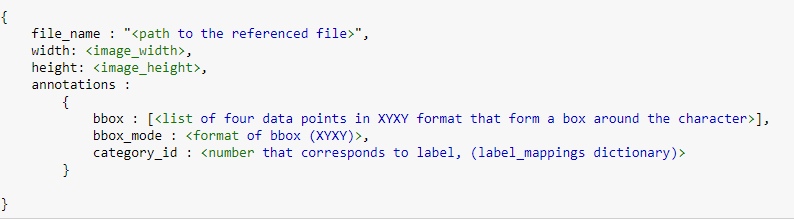

In [5]:
def get_formatted_data(json_path=path_to_training_batch + "JSON/kaggle_data_1.json", batch_path=path_to_training_batch + "background_images/"):
    
    data = []

    json_data = get_json_data(json_path)
    
    id = 0

    for image in range(len(json_data)): # need to format the annotations for each image
        current = json_data[image]["image_data"]
            
        if Path(batch_path + json_data[image]["filename"]).exists(): # make sure the image exists in storage
        
            anns = []
            for i in range(len(current["xmins_raw"])):
              bboxes = [current["xmins_raw"][i], current["ymins_raw"][i], current["xmaxs_raw"][i], current["ymaxs_raw"][i]]

              obj = {
                "bbox" : bboxes,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id" : get_label_mapping()[current["visible_latex_chars"][i]]
              }
              anns.append(obj)


            data.append({
                "file_name" : batch_path + json_data[image]["filename"],
                "image_id" : id,
                "width" : current["width"],
                "height" : current["height"],
                "annotations" : anns
            })
            
            id = id + 1


    return data

    

## Registering the Dataset

Now detectron needs to know about the dataset. Most of the work is done since a function has already been made that provides this dataset. But two things need to happen still

1. Register Dataset
2. Register Metadata

The dataset is the values, the bounding box, and everything that was formatted above. Whereas the Metadata is just the labels that these annotations can have. Detectron2 provides tools in order to register these. 

In [6]:
DatasetCatalog.register("calc_training", lambda: get_formatted_data())
MetadataCatalog.get("calc_training").thing_classes = list(get_label_mapping().keys())

DatasetCatalog.register("calc_testing", lambda: get_formatted_data(batch_path=path_to_testing_batch + "background_images/", json_path=path_to_testing_batch+"JSON/kaggle_data_2.json"))
MetadataCatalog.get("calc_testing").thing_classes = list(get_label_mapping().keys())

Let's see if importing the data really worked now.....

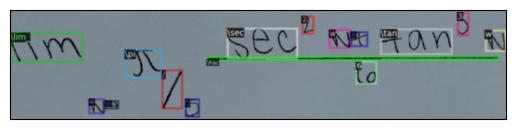

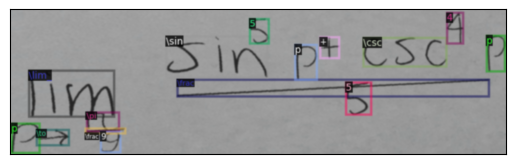

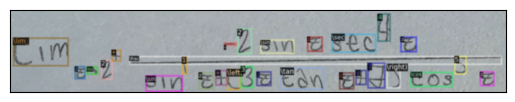

In [7]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt 

data = get_formatted_data()

for image in random.sample(data, 3):
    img = cv2.imread(image["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=MetadataCatalog.get("calc_training"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(image)
    plt.imshow(out.get_image()[:, :, ::-1], cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# Training the Data

This is the most basic configuration there is. Detectron2 offers pretrained models, the one being used in this is a pretrained RCNN. This is just to ensure that the training works at the very least. Optimizations will be made in the next iteration of this. 

In [8]:
from detectron2.engine import DefaultTrainer


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("calc_training",)
cfg.DATASETS.TEST = ("calc_testing",) 
cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 300    
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 54

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/03 21:22:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/03 21:22:47 d2.data.build]: Removed 0 images with no usable annotations. 10000 images left.
[12/03 21:22:47 d2.data.build]: Distribution of instances among all 54 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   \lim_    | 11147        |     a      | 1428         |    \to     | 11147        |
|   \frac    | 14868        |    \pi     | 4506         |     4      | 4332         |
|     d      | 5932         |   \left(   | 6258         |    \sin    | 3998         |
|     +      | 11864        |     -      | 9468         |     6      | 4303         |
|    \sec    | 1141         |  \right)   | 6258         |     w      | 3086         |
|     /      | 2599         |     5      | 4217         |    \tan    | 3513         |
|     2      | 9055         |     3      | 6363         |     e      | 699          |
|     b      | 1596         |     7      | 4192

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (55, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (55,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (216, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (216,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[12/03 21:22:48 d2.engine.train_loop]: Starting training from iteration 0


/home/jefferse/.conda/envs/local_detectron/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/03 21:22:57 d2.utils.events]:  eta: 0:01:29  iter: 19  total_loss: 6.81  loss_cls: 4.004  loss_box_reg: 0.8314  loss_rpn_cls: 1.607  loss_rpn_loc: 0.4029    time: 0.3330  last_time: 0.2732  data_time: 0.0123  last_data_time: 0.0026   lr: 1.6068e-05  max_mem: 2459M
[12/03 21:23:05 d2.utils.events]:  eta: 0:01:23  iter: 39  total_loss: 5.253  loss_cls: 3.722  loss_box_reg: 0.8655  loss_rpn_cls: 0.1732  loss_rpn_loc: 0.3882    time: 0.3366  last_time: 0.2295  data_time: 0.0043  last_data_time: 0.0029   lr: 3.2718e-05  max_mem: 2548M
[12/03 21:23:11 d2.utils.events]:  eta: 0:01:15  iter: 59  total_loss: 4.416  loss_cls: 3.046  loss_box_reg: 0.8516  loss_rpn_cls: 0.07863  loss_rpn_loc: 0.3407    time: 0.3244  last_time: 0.2430  data_time: 0.0027  last_data_time: 0.0028   lr: 4.9367e-05  max_mem: 2639M
[12/03 21:23:17 d2.utils.events]:  eta: 0:01:09  iter: 79  total_loss: 3.119  loss_cls: 1.714  loss_box_reg: 0.8609  loss_rpn_cls: 0.07672  loss_rpn_loc: 0.3565    time: 0.3230  last_time:

WARNING [12/03 21:24:39 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


# Predict

Now that it is trained, the model can make predictions on images that it has never seen before. Predictions are done by loading in the final weights of the training into the testing model. These can be visualized in the same way that the previous visualizations were made. 

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = '/home/jefferse/aimathsolverproject/output/model_final.pth'
cfg.MODEL.WEIGHTS = "/home/jefferse/aimathsolverproject/output/model_final.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 54
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

In [15]:
predictor = DefaultPredictor(cfg)

[12/03 21:25:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jefferse/aimathsolverproject/output/model_final.pth ...


{'instances': Instances(num_instances=23, image_height=274, image_width=1088, fields=[pred_boxes: Boxes(tensor([[ 314.7049,  124.5098,  357.3281,  186.2475],
        [ 317.0734,  135.6715,  356.2568,  166.5793],
        [ 329.0844,  127.5368,  361.6451,  175.4352],
        [ 194.8575,  194.9070,  240.3581,  237.8567],
        [ 236.5698,  181.6183,  277.7888,  233.7923],
        [ 448.3429,  146.2122,  501.9906,  175.4870],
        [ 318.8203,  127.4406,  343.6411,  174.3980],
        [1024.7542,  189.3743, 1086.9374,  266.1584],
        [   6.2653,   15.5140,   57.9070,  149.1822],
        [ 728.5594,  119.1215,  782.8080,  190.6980],
        [ 590.7506,  108.4114,  687.2528,  217.8195],
        [ 842.3857,  167.6002,  894.4599,  213.8825],
        [ 730.2815,  129.3630,  799.9340,  215.7913],
        [ 919.2916,  168.7418,  961.6370,  213.2940],
        [ 295.4219,  104.8370,  367.7599,  176.4659],
        [ 237.6013,  187.1389,  286.5403,  229.8670],
        [ 201.2706,  192.2960,  

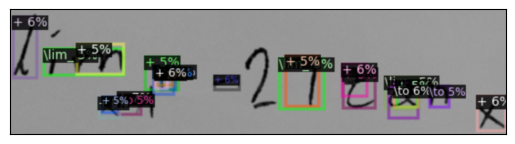

{'instances': Instances(num_instances=23, image_height=367, image_width=1702, fields=[pred_boxes: Boxes(tensor([[7.5715e+02, 6.1565e+01, 8.1585e+02, 1.3623e+02],
        [1.1223e+03, 6.9187e+01, 1.1689e+03, 1.2264e+02],
        [1.5722e+03, 8.9716e+01, 1.6408e+03, 1.7334e+02],
        [1.0643e+03, 7.6969e+01, 1.1335e+03, 1.6431e+02],
        [2.5289e+02, 2.9265e+02, 3.1597e+02, 3.2585e+02],
        [3.3483e+02, 1.0099e+02, 4.4454e+02, 2.4677e+02],
        [2.1204e+02, 2.9281e+02, 2.6111e+02, 3.5972e+02],
        [1.5895e+03, 7.7770e+01, 1.6493e+03, 1.5748e+02],
        [3.3188e+02, 1.5522e+02, 4.4451e+02, 2.5081e+02],
        [1.1217e+03, 6.9956e+01, 1.1695e+03, 1.2279e+02],
        [5.8312e+00, 5.3411e+01, 2.1317e+02, 1.9734e+02],
        [3.2470e+02, 1.4980e+02, 4.6262e+02, 2.7236e+02],
        [9.3572e+02, 7.6927e+00, 1.0079e+03, 1.2645e+02],
        [4.9253e+02, 1.8371e+02, 1.7020e+03, 2.1669e+02],
        [3.5664e+02, 1.5598e+02, 4.4083e+02, 2.5628e+02],
        [3.1941e+02, 1.489

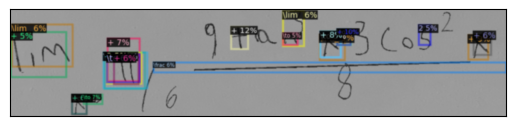

{'instances': Instances(num_instances=17, image_height=364, image_width=816, fields=[pred_boxes: Boxes(tensor([[295.9321, 262.9095, 329.7308, 287.9310],
        [704.0026, 276.8108, 763.0047, 310.5281],
        [421.2787, 232.7274, 816.0000, 262.3007],
        [241.4584, 265.0767, 301.2384, 313.8714],
        [478.2540, 242.0326, 816.0000, 259.1355],
        [434.0577, 116.1404, 464.2713, 148.2430],
        [ 17.4418, 299.2761,  61.4699, 328.4442],
        [254.7097, 277.3091, 291.8322, 312.6108],
        [690.9816, 280.2928, 741.8711, 308.7230],
        [687.2479, 265.3131, 749.7258, 314.7017],
        [115.9271, 210.4105, 164.9854, 271.9645],
        [382.7326, 255.8113, 434.3877, 315.8420],
        [ 57.4977, 283.9757, 101.1933, 316.3880],
        [590.7357, 271.0532, 637.7142, 316.8367],
        [240.0589, 281.6111, 278.2924, 312.7165],
        [340.7086, 268.9301, 373.1864, 290.9644],
        [428.7900, 118.8538, 486.2697, 144.2013]], device='cuda:0')), scores: tensor([0.0919, 0.0

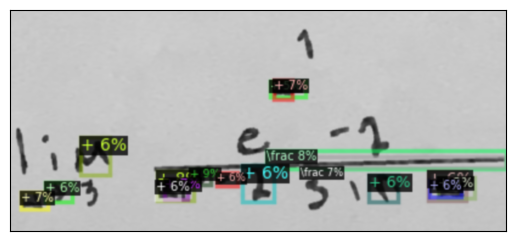

In [16]:
data = get_formatted_data(batch_path=path_to_testing_batch + "background_images/", json_path=path_to_testing_batch+"JSON/kaggle_data_2.json")

for image in random.sample(data, 3):
    img = cv2.imread(image["file_name"])

    outputs = predictor(img)
    print(outputs)
    print(get_label_mapping())
    v = Visualizer(img[:, :, ::-1],
                   metadata=MetadataCatalog.get("calc_testing"),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1], cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

# Accuracy

In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("calc_testing", ("bbox", "segm"), False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "calc_testing")
print(inference_on_dataset(trainer.model, test_loader, evaluator))

[12/03 21:25:28 d2.evaluation.coco_evaluation]: Trying to convert 'calc_testing' to COCO format ...
WARNING [12/03 21:25:28 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/calc_testing_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[12/03 21:25:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/03 21:25:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/03 21:25:29 d2.data.common]: Serializing 2560 elements to byte tensors and concatenating them all ...
[12/03 21:25:29 d2.data.common]: Serialized dataset takes 1.86 MiB
[12/03 21:25:29 d2.evaluation.evaluator]: Start inference on 2560 batches
[12/03 21:25:30 d2.evaluation.evaluator]: Inference done 11/2560. Dataloading: 0.0006 s/iter. Inference: 0.0708 s/iter. Eval: 0.0002 s/iter. Total:

Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
[12/03 21:28:31 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[12/03 21:28:34 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 2.57 seconds.
[12/03 21:28:34 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[12/03 21:28:34 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.34 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.016
 Avera

TypeError: list indices must be integers or slices, not str

# Accuracy Metrics

|  AP   |  AP50  |  AP75  |  APs  |  APm  |  APl  |
|:-----:|:------:|:------:|:-----:|:-----:|:-----:|
| 1.236 | 2.544  | 0.882  | 0.730 | 1.114 | 0.887 |

| category   | AP     | category   | AP    | category   | AP    |
|:-----------|:-------|:-----------|:------|:-----------|:------|
| \lim_      | 17.269 | a          | 0.000 | \to        | 8.203 |
| \frac      | 6.259  | \pi        | 0.000 | 4          | 0.000 |
| d          | 0.000  | \left(     | 0.000 | \sin       | 0.000 |
| +          | 34.855 | -          | 0.000 | 6          | 0.000 |
| \sec       | 0.000  | \right)    | 0.000 | w          | 0.000 |
| /          | 0.000  | 5          | 0.000 | \tan       | 0.000 |
| 2          | 0.156  | 3          | 0.000 | e          | 0.000 |
| b          | 0.000  | 7          | 0.000 | \cos       | 0.000 |
| \theta     | 0.000  | 8          | 0.000 | =          | 0.000 |
| x          | 0.000  | 9          | 0.000 | 1          | 0.000 |
| y          | 0.000  | h          | 0.000 | k          | 0.000 |
| g          | 0.000  | \csc       | 0.000 | \infty     | 0.000 |
| 0          | 0.000  | \sqrt      | 0.000 | r          | 0.000 |
| \ln        | 0.000  | n          | 0.000 | u          | 0.000 |
| \cot       | 0.000  | \left|     | 0.000 | \right|    | 0.000 |
| p          | 0.000  | t          | 0.000 | z          | 0.000 |
| \log       | 0.000  | v          | 0.000 | s          | 0.000 |
| c          | 0.000  | \cdot      | 0.000 | .          | 0.000 |